然而采用Ariam等模型对金融事件序列建模效果是非常差的，原因就在于金融事件序列的异方差性。这种非平稳性无法用简单的差分去消除，其根本原因在于其二阶矩随时间t变化而变化。

异方差描述的是金融时间序列大的趋势，时间跨度相对较长。金融时间序列的另一个特征是波动聚集，它是在小时间尺度下的波动特性（可以理解为小尺度下的异方差表现）。一般来讲，金融时间序列的波动具有大波动接着大波动，小波动接着小波动的特征，即波峰和波谷具有连续性。在高波动的时候，人们情绪高涨市场的势能不断积累，于是会转化成更大的波动；在低波动的时候，人们对市场的兴趣越来越低，市场逐渐会成为一摊死水。此外，金融事件序列存在波动的不对称性，在上涨时候的波动率会小于下跌时候的波动率。

Garch模型作为现代的金融事件序列模型，是基于波动聚集这个特性建模的。波动聚集告诉我们当前的波动率是和过去的波动率存在一定的关系，方差的概念也相应的扩展到条件方差，所谓条件反差指的是过去时刻信息已知的方差。Garch模型认为本期的条件方差是过去N期条件方差和序列平方的线性组合，而序列是本期条件方差和白噪声的乘积。

In [1]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt     
#tsa为Time Series analysis缩写
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
#画图
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [2]:
def ts_plot(data, lags=None,title=''):
    if not isinstance(data, pd.Series):   
        data = pd.Series(data)
    #matplotlib官方提供了五种不同的图形风格，
    #包括bmh、ggplot、dark_background、fivethirtyeight和grayscale
    with plt.style.context('ggplot'):    
        fig = plt.figure(figsize=(10, 8))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        data.plot(ax=ts_ax)
        ts_ax.set_title(title+'时序图')
        smt.graphics.plot_acf(data, lags=lags, ax=acf_ax, alpha=0.5)
        acf_ax.set_title('自相关系数')
        smt.graphics.plot_pacf(data, lags=lags, ax=pacf_ax, alpha=0.5)
        pacf_ax.set_title('偏自相关系数')
        sm.qqplot(data, line='s', ax=qq_ax)
        qq_ax.set_title('QQ 图')        
        scs.probplot(data, sparams=(data.mean(), data.std()), plot=pp_ax)
        pp_ax.set_title('PP 图') 
        plt.tight_layout()
    return

In [3]:
import tushare as ts
token='e0eeb08befd1f07516df2cbf9cbd58663f77fd72f92a04f290291c9d'
pro=ts.pro_api(token)
df=pro.index_daily(ts_code='000300.SH')
df.index=pd.to_datetime(df.trade_date)
del df.index.name
df=df.sort_index()
df['ret']=np.log(df.close/df.close.shift(1))
df.head()

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount,ret
2005-01-04,000300.SH,20050104,982.794,994.769,994.769,980.658,1000.000,-17.206,-1.7206,7412868.94,4431977.418,NaN
2005-01-05,000300.SH,20050105,992.564,981.577,997.323,979.877,982.794,9.770,0.9941,7119108.98,4529208.214,0.009892
2005-01-06,000300.SH,20050106,983.174,993.331,993.788,980.330,992.564,-9.390,-0.9460,6288029.05,3921015.420,-0.009505
2005-01-07,000300.SH,20050107,983.958,983.045,995.711,979.812,983.174,0.784,0.0797,7298694.09,4737469.399,0.000797
2005-01-10,000300.SH,20050110,993.879,983.760,993.959,979.789,983.958,9.921,1.0083,5791697.99,3762932.890,0.010032


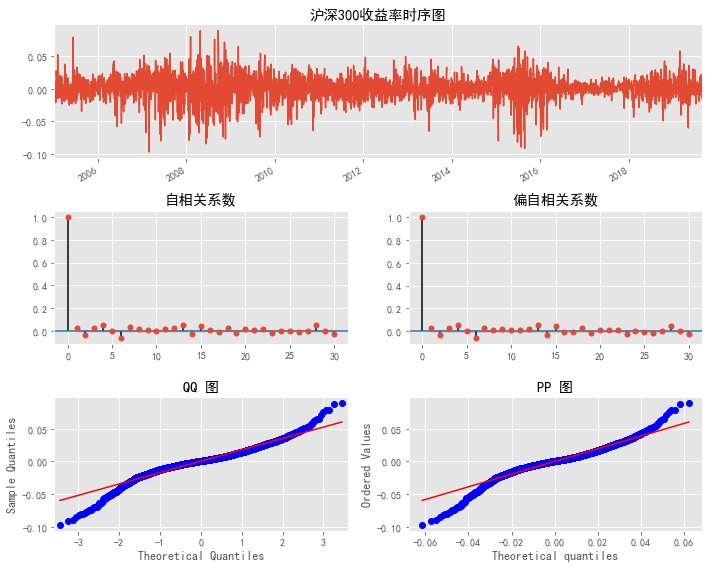

In [16]:
ts_plot(df.ret.dropna(),lags=30,title='沪深300收益率')

金融资产收益率的时间序列存在以下几个普遍的现象：
- 时间序列本身的自相关性比较弱，但对其进行变换后，如取对数、平方、绝对值等，则表现出很强的自相关性；
- 资产收益率的条件方差（Conditional Variance）会随着时间而变化，即存在条件异方差的特征；
- 资产收益率序列的波动具有持续性，即存在波动集聚（Volatility Clustering）的现象；
- 许多资产收益率序列，并不服从正态分布，其极端值较多，具有厚尾（Heavy Tail）的现象。

ARCH和GARCH模型的出现就是为了捕捉时间序列的上述现象。

# ARCH模型
ARCH模型全称是自回归条件异方差模型，Autoregressive Conditionally Heteroskedastic Models - ARCH(p)，是Engle在1982年分析英国通货膨胀率时提出的模型，主要用于刻画波动率的统计特征。一般先假设收益率序列${y_t}$满足某个经典时间序列模型（MA、AR或ARMA），以AR（1）模型为例：

$$y_t=\alpha_0+\alpha_1y_{t-1}+\varepsilon_t$$

则收益率$y_t$的波动率（条件方差）可以使用残差项$\varepsilon_t$的波动率进行刻画：

$$Var(y_t|y_{t-1})=Var(\varepsilon_t|y_{t-1})$$

波动率集聚指高波动率和低波动率往往会各自聚集在某一时间段，而且高波动率和低波动率聚集的时期会交替出现。为了刻画资产收益率的这种波动特性，可以另$\varepsilon_t$的条件方差与过去残差项的平方有关。所以，ARCH（p）模型可以表示为：

$$\varepsilon_t=\sigma_t\omega_t\\\sigma_t^2=\alpha_0+\alpha_1\varepsilon_{t-1}^2+...+\alpha_p\varepsilon_{t-p}^2$$

其中，${\omega_t}$是均值为0，方差为1的独立同分布时间序列，$\alpha_0>0,\alpha_i\geq0$，且满足一定条件使得$\varepsilon_t$的无条件方差有限。
ARCH(p)模型能够很好地刻画资产收益率序列的波动特性和厚尾现象，但是其本身并不能用来解释金融资产收益率为何有这样的特征。

ARCH(p)模型的估计过程：
- 设定合适的滞后阶数p。在检验时间序列${\varepsilon_t}$确实存在显著的ARCH效应的基础上，使用${\varepsilon_t^2}$的偏自相关函数（PACF）来确定p。
- 阶数确定后，为估计参数，可以假定$\omega_t$服从以下三种分布中的一种来估计：标准正态分布、标准化的学生t分布和广义误差分布。然后用最大似然法（Maximum Likelihood）估计模型参数。
- 对模型设定进行检验。一般正确设定的ARCH模型，其标准化残差是独立同分布的随机过程，因此标准化残差和其平方项的Ljung-Box统计量可以分别用来检验均值方差和波动率方差的设定是否正确。

ARCH模型的建模步骤：
- 检验收益率序列${y_t}$是否平稳，并根据其相关性建立合适的均值方程，如ARMA模型，描述收益率$y_t$如何随时间变化，根据拟合的模型和实际值，得到残差序列{$\hat{\varepsilon}_t$}
- 对拟合的均值方程得到的残差序列{$\hat{\varepsilon}_t$}进行ARCH效应检验，即检验收益率围绕均值的偏差是否时大时小。检验序列是否具有ARCH效应的方法有两种：
  （1）用Ljung-Box检验残差平方序列的自相关性，即将序列的平方值作为波动率的代理变量，若残差序列有自相关性，则说明当期波动与过去期波动有关，初步判别序列有ARCH效应。
  （2）用Engle提出的LM检验，用公式表示为：
  $$\hat{\varepsilon}_t^2=\hat{\alpha}_0+\sum_{i=1}^p\hat{\alpha}_i\hat{\varepsilon}_{t-1}^2$$
  
  检验的原假设为：序列{$\hat{\varepsilon}_t$}无ARCH效应，即$\alpha_i=0,i=1,..,q$。备择假设是{$\hat{\varepsilon}_t$}具有ARCH效应，即至少有一个$\alpha_i$显著不为0。

- 若ARCH效应在统计上显著，则需要再设定一个波动率模型来刻画波动率的动态变化。
- 对均值方差和波动率方差进行联合估计，即假设实际数据服从前面设定的均值方差和波动率方差后，对均值方差和波动率方差中的参数进行估计，并得到估计的误差。
- 对拟合的模型进行检验。如果估计结果（残差项）不满足模型本身的假设，则模型的可用性值得怀疑。

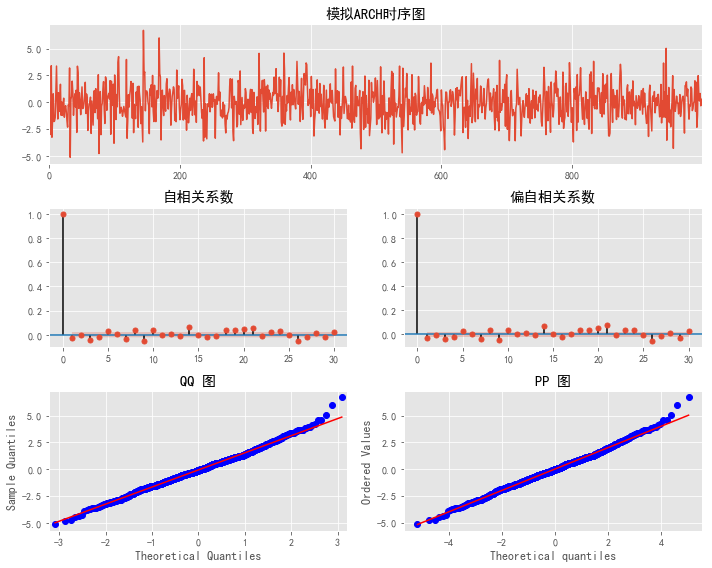

In [5]:
# 模拟ARCH时间序列
np.random.seed(2)
a0 = 2
a1 = .5
y = w = np.random.normal(size=1000)
Y = np.empty_like(y)
for t in range(1,len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))
ts_plot(Y, lags=30,title='模拟ARCH')

In [17]:
df.head()

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount,ret
2005-01-04,000300.SH,20050104,982.794,994.769,994.769,980.658,1000.000,-17.206,-1.7206,7412868.94,4431977.418,NaN
2005-01-05,000300.SH,20050105,992.564,981.577,997.323,979.877,982.794,9.770,0.9941,7119108.98,4529208.214,0.009892
2005-01-06,000300.SH,20050106,983.174,993.331,993.788,980.330,992.564,-9.390,-0.9460,6288029.05,3921015.420,-0.009505
2005-01-07,000300.SH,20050107,983.958,983.045,995.711,979.812,983.174,0.784,0.0797,7298694.09,4737469.399,0.000797
2005-01-10,000300.SH,20050110,993.879,983.760,993.959,979.789,983.958,9.921,1.0083,5791697.99,3762932.890,0.010032


In [26]:
def ret_plot(ts, title=''):
    ts1=ts**2
    ts2=np.abs(ts)
    with plt.style.context('ggplot'):    
        fig = plt.figure(figsize=(12, 6))
        layout = (2, 1)
        ts1_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        ts2_ax = plt.subplot2grid(layout, (1, 0))
        ts1.plot(ax=ts1_ax)
        ts1_ax.set_title(title+'日收益率平方')
        ts2.plot(ax=ts2_ax)
        ts2_ax.set_title(title+'日收益率绝对值')
        plt.tight_layout()
    return

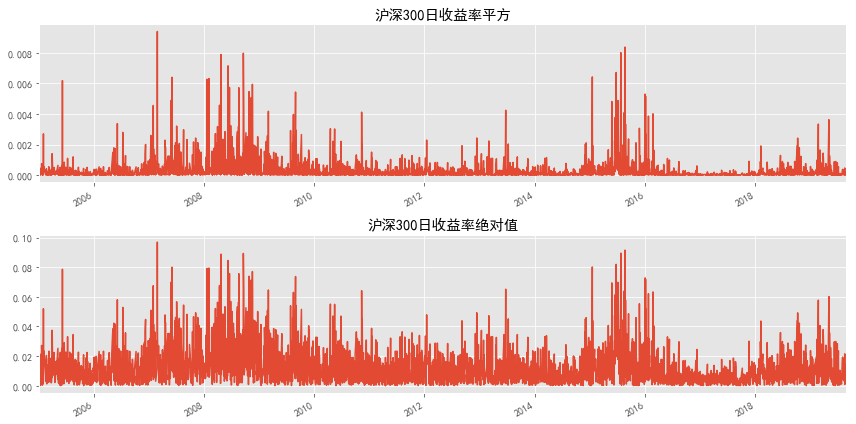

In [27]:
ret_plot(df.ret.dropna(), title='沪深300')

从沪深300的日收益平方和绝对值走势图可以看出，存在较明显的波动聚集的现象，初步可以判断出沪深300日收益序列存在ARCH效应。下面使用Ljung-Box统计量对收益率平方的自相关性进行统计检验。

#计算Q统计量和LB统计量都是用python中statsmodels模块中的acorr_ljungbox方法. 默认情况下, acorr_ljungbox只计算LB统计量, 只有当参数boxpierce=True时, 才会输出Q统计量

In [106]:
def whitenoise_test(ts):
    '''计算box pierce 和 box ljung统计量'''
    from statsmodels.stats.diagnostic import acorr_ljungbox
    q,p=acorr_ljungbox(ts)
    with plt.style.context('ggplot'):    
        fig = plt.figure(figsize=(10, 4))
        axes = fig.subplots(1,2)
        axes[0].plot(q, label='Q统计量')
        axes[0].set_ylabel('Q')
        axes[1].plot(p, label='p值')
        axes[1].set_ylabel('P')
        axes[0].legend()
        axes[1].legend()
        plt.tight_layout()
    return

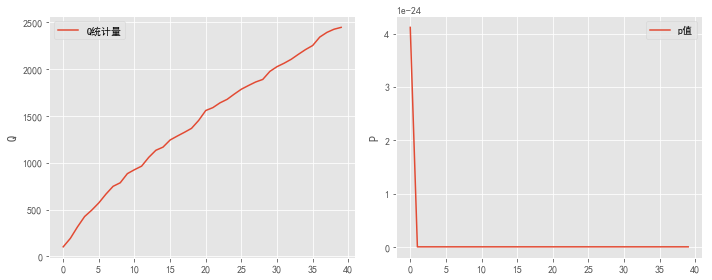

In [107]:
ret=df.ret.dropna()
whitenoise_test(ret**2)

由LB白噪声检验可以看出，Q统计量的p值都在0.05以下, 表明原假设成立的概率极小, 可以拒绝沪深300收益率的平方是白噪音序列的原假设，说明原序列（沪深300收益率）存在ARCH效应。

# GARCH模型

GARCH模型是Bollerslev在1986年提出来的，全称为广义自回归条件异方差模型，Generalized Autoregressive Conditionally Heteroskedastic Models - GARCH(p,q)，是ARCH模型的扩展。GARCH模型认为时间序列每个时间点变量的波动率是最近p个时间点残差平方的线性组合，与最近q个时间点变量波动率的线性组合加起来得到，即GARCH模型的条件方差不仅是滞后残差平方的线性函数，还是滞后条件方差的线性函数，因而GARCH模型适合在计算量不大时，方便地描述高阶的ARCH过程，具有更大的适用性。

$$\varepsilon_t =\sigma_t\omega_t\\ \sigma_t^2 =\alpha_0+\sum_{i=1}^p\alpha_i\varepsilon_{t-i}^2+\sum_{j=1}^q\beta_j\sigma_{t-j}^2$$

其中，$\omega_t$为白噪音，$\sum_{i=1}^p\alpha_i+\sum_{j=1}^q\beta_j<1$，否则模型将是非平稳的。GARCH模型的估计与ARCH模型类似，具体推导过程参见计量经济学相关书籍。在实际应用找那个，GARCH(1,1)和GARCH(2,1)一般可以满足对自回归条件异方差的描述。

ARCH与GARCH模型的不足之处：
- 模型都假定波动是对称的，即过去的波动对现在条件方差的影响是相同的，但学术上的实证结果却表明，当坏（好）消息发布时，股票收益率的波动会增加（减小）。
- 模型对参数的限制条件较强，尤其是高阶模型，参数需要满足的约束非常复杂。
- 模型并没有提供关于波动率变化的更进一步解释，而仅仅是拟合波动率变化的统计行为，要进一步理解波动率的动态变化还需要其他理论。

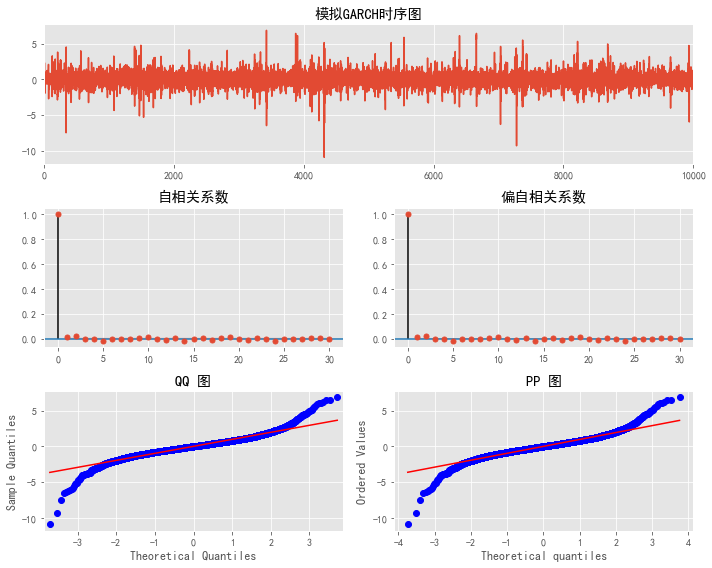

In [109]:
# 模拟GARCH(1, 1) 过程
np.random.seed(1)
a0 = 0.2
a1 = 0.5
b1 = 0.3
n = 10000
w = np.random.normal(size=n)
garch = np.zeros_like(w)
sigsq = np.zeros_like(w)
for i in range(1, n):
    sigsq[i] = a0 + a1*(garch[i-1]**2) + b1*sigsq[i-1]
    garch[i] = w[i] * np.sqrt(sigsq[i])
_ = ts_plot(garch, lags=30,title='模拟GARCH')

arch.arch_model(y, x=None, mean='Constant', lags=0, vol='Garch', p=1, o=0, q=1, power=2.0, dist='Normal', hold_back=None)
使用便利函数以便arch模型快速初始化：
各参数含义:	
y : 因变量；x : 外生变量.如果没有外生变量则模型自动省略。  
mean: 均值模型的名称.目前支持: ‘Constant’, ‘Zero’, ‘ARX’ 以及 ‘HARX’。  
lags:用来表明滞后阶，或者使用表明滞后位置的整数列表。  
vol :波动率模型的名称，目前支持: ‘GARCH’ （默认）, ‘ARCH’, ‘EGARCH’, ‘FIARCH’ 以及 ‘HARCH’。  
p :– 对称随机数的滞后阶,即扣除均值后的部分。  
o ：非对称数据的滞后阶。  
q ：波动率或对应变量的滞后阶。  
power：使用GARCH或相关模型的精度。  
dist：误差分布的名称，目前支持下列分布：正态分布: ‘normal’, ‘gaussian’ (default)；学生T分布: ‘t’, ‘studentst’；偏态学生T分布: ‘skewstudent’, ‘skewt’；通用误差分布: ‘ged’, ‘generalized error”。  
hold_back：估计模型参数时样本最初需排除的观察值数. 对同一样本使用不同的滞后阶来比较模型时使用该参数。

模型可以从三个方面构建：
（1）均值模型(arch.mean)  
- 0均值 (ZeroMean) - 适合单独使用模型残差。
- 常数均值(ConstantMean) - 适用于多数流动金融资产。
- 可选外生变量自回归 (ARX)
- 可选外生变量异方差自回归
- 仅仅外生回归 (LS)  

（2）波动率过程 (arch.volatility)
- ARCH (ARCH)
- GARCH (GARCH)
- GJR-GARCH (GARCH using o argument)
- TARCH/ZARCH (GARCH using power argument set to 1)
- Power GARCH and Asymmetric Power GARCH (GARCH using power)
- 使用估计系数的指数加权平均移动方差 (EWMAVariance)
- 异方差 ARCH (HARCH)
- 参数模型  
  指数加权平均移动方差,即为风险指标 RiskMetrics (EWMAVariance)  
   EWMAs的加权平均数,即为 RiskMetrics 2006 方法风险指标 (RiskMetrics2006)

（3）分布 (arch.distribution)
- Normal (Normal)
- Standardized Students’s T (StudentsT)

In [119]:
# 使用模拟的数据进行 GARCH(1, 1) 模型拟合
#arch_model默认建立GARCH（1,1）模型
am = arch_model(garch)
res = am.fit(update_freq=0)
#update_freq=0表示不输出中间结果，只输出最终结果
print(res.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12199.134540521049
            Iterations: 14
            Function evaluations: 94
            Gradient evaluations: 14
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12199.1
Distribution:                  Normal   AIC:                           24406.3
Method:            Maximum Likelihood   BIC:                           24435.1
                                        No. Observations:                10000
Date:                Fri, Aug 30 2019   Df Residuals:                     9996
Time:                        15:35:51   Df Model:                            4
                                  Mean Model                                  

In [ ]:
#拟合沪深300收益率数据

In [143]:
Y=ret*100.0
am = arch_model(Y,p=1, o=1, q=1, dist='StudentsT')
res = am.fit(update_freq=0)
#update_freq=0表示不输出中间结果，只输出最终结果
print(res.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6393.314593143568
            Iterations: 18
            Function evaluations: 158
            Gradient evaluations: 18
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                          ret   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -6393.31
Distribution:      Standardized Student's t   AIC:                           12798.6
Method:                  Maximum Likelihood   BIC:                           12835.7
                                              No. Observations:                 3562
Date:                      Fri, Aug 30 2019   Df Residuals:                     3556
Time:                              16:54:56   Df Model:                            6
                        

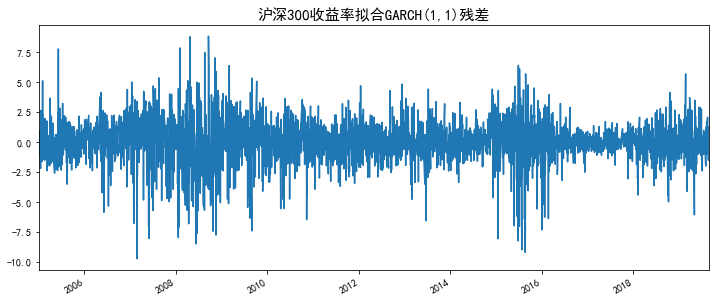

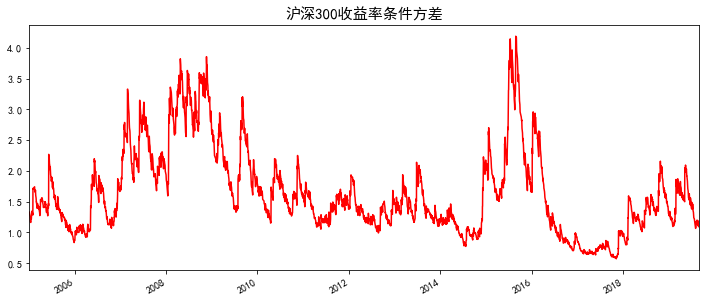

In [150]:
res.resid.plot(figsize=(12,5))
plt.title('沪深300收益率拟合GARCH(1,1)残差',size=15)
plt.show()
res.conditional_volatility.plot(figsize=(12,5),color='r')
plt.title('沪深300收益率条件方差',size=15)
plt.show()

In [154]:
hs300=pd.DataFrame()
hs300['close']=df.loc[res.resid.index]['close']
hs300['ret']=df.loc[res.resid.index]['ret']*100
hs300['garch']=res.conditional_volatility
hs300.head()

,close,ret,garch
2005-01-05,992.564,0.989196,1.330652
2005-01-06,983.174,-0.950538,1.314440
2005-01-07,983.958,0.079710,1.304088
2005-01-10,993.879,1.003226,1.271587
2005-01-11,997.135,0.327070,1.258477


波动建模有以下量化投资方向的应用：

期权定价：波动率是影响期权价值的重要因素；  
风险度量和管理：在VaR的计算中波动率是主要影响因素，根据波动率决定交易策略的杠杆；  
资产价格预测和模拟：通过Garch簇模型对资产价格的时间序列进行预测和模拟；  
调仓：盯住波动率的调仓策略，如一个tracing指数的策略；  
作为交易标的：在VIX、ETF以及远期中波动率作为标的可以直接交易。

模拟时间序列变量的波动性的变化，它在金融工程学的实证研究中应用广泛，使人们能更加准确地把握风险（波动性），尤其是应用在风险价值（Value at Risk）理论中

[参考资料](https://blog.csdn.net/liuxoxo?t=1)